In [ ]:
!pip install wandb

In [21]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
!unzip "/content/drive/MyDrive/archive.zip" -d .

In [23]:
from __future__ import print_function
import argparse
import os
import random
import torch
import wandb
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print('setup done')

setup done


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
batch_size = 64
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 100
lr = 0.0002
beta1 = 0.5
ngpu = 1
print_every = 250
device = torch.device("cuda:0")
workers = 2

In [24]:
#  start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Exploring GAN",
    config={
    "learning_rate": lr,
    "architecture": "CNN",
    "dataset": "celebrity-face-image-dataset",
    "epochs": num_epochs,
    }
)

wandb: Currently logged in as: sefinehtesfa34 (aauaait). Use `wandb login --relogin` to force relogin


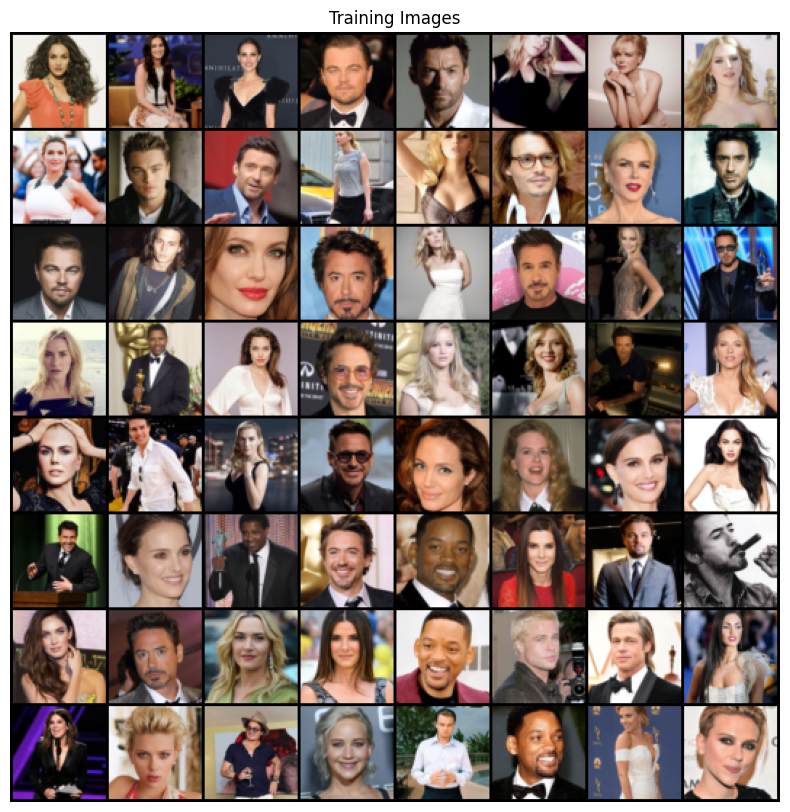

In [8]:
dataset_transforms = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = dset.ImageFolder(root='./dataset/', transform=dataset_transforms)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Model Implementation

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [12]:
netG = Generator().to(device)
netG.apply(weights_init)
netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [13]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
import torch
import torch.nn as nn
import torchvision.utils as vutils

# Initialize networks, optimizer, criterion, etc. (assuming they are defined elsewhere)
# netG, netD, optimizerG, optimizerD, criterion, dataloader, device, num_epochs, print_every, nz, fixed_noise, real_label, fake_label are assumed to be defined properly

img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, (img, _) in enumerate(dataloader, 0):
        # Update Discriminator network
        netD.zero_grad()

        real_data = img.to(device)
        b_size = real_data.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = netD(real_data).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Generate fake data
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)

        # Update Discriminator with fake data
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        # Update Generator network
        netG.zero_grad()
        label.fill_(real_label)  # reset labels for generator update
        output = netD(fake).view(-1)

        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Logging and visualization
        if i % print_every == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Save generated images for visualization
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


[0/100][0/29]	Loss_D: 0.3622	Loss_G: 4.1639	D(x): 0.8998	D(G(z)): 0.1677 / 0.0297
[1/100][0/29]	Loss_D: 0.8766	Loss_G: 2.0072	D(x): 0.5481	D(G(z)): 0.0567 / 0.2393
[2/100][0/29]	Loss_D: 0.2940	Loss_G: 4.2909	D(x): 0.8983	D(G(z)): 0.1461 / 0.0240
[3/100][0/29]	Loss_D: 0.7386	Loss_G: 5.3635	D(x): 0.8744	D(G(z)): 0.3180 / 0.0100
[4/100][0/29]	Loss_D: 1.0441	Loss_G: 2.6388	D(x): 0.5023	D(G(z)): 0.0132 / 0.1663
[5/100][0/29]	Loss_D: 0.8003	Loss_G: 4.2595	D(x): 0.6180	D(G(z)): 0.0796 / 0.0568
[6/100][0/29]	Loss_D: 0.4142	Loss_G: 3.3942	D(x): 0.8311	D(G(z)): 0.1461 / 0.0608
[7/100][0/29]	Loss_D: 0.3487	Loss_G: 3.4771	D(x): 0.8064	D(G(z)): 0.0899 / 0.0648
[8/100][0/29]	Loss_D: 0.5036	Loss_G: 6.1260	D(x): 0.9292	D(G(z)): 0.2637 / 0.0060
[9/100][0/29]	Loss_D: 0.5684	Loss_G: 5.1956	D(x): 0.8929	D(G(z)): 0.2503 / 0.0152
[10/100][0/29]	Loss_D: 0.6955	Loss_G: 6.9058	D(x): 0.9105	D(G(z)): 0.3486 / 0.0025
[11/100][0/29]	Loss_D: 0.3395	Loss_G: 4.5789	D(x): 0.7829	D(G(z)): 0.0465 / 0.0312
[12/100][0/29]

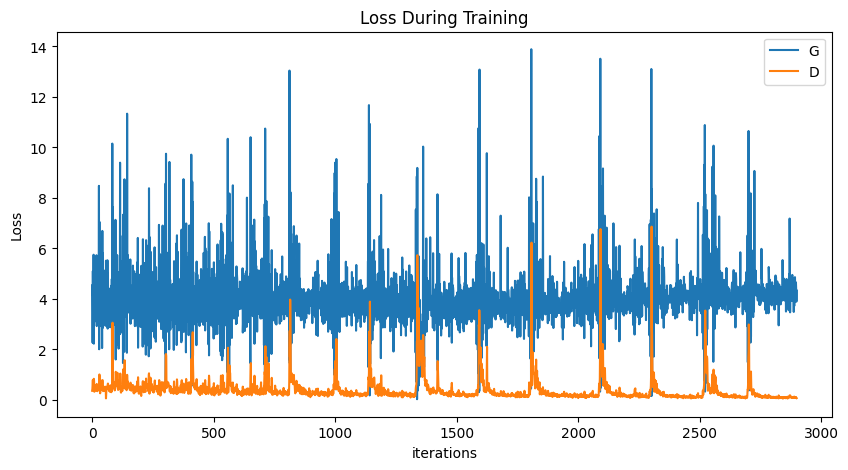

In [28]:
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

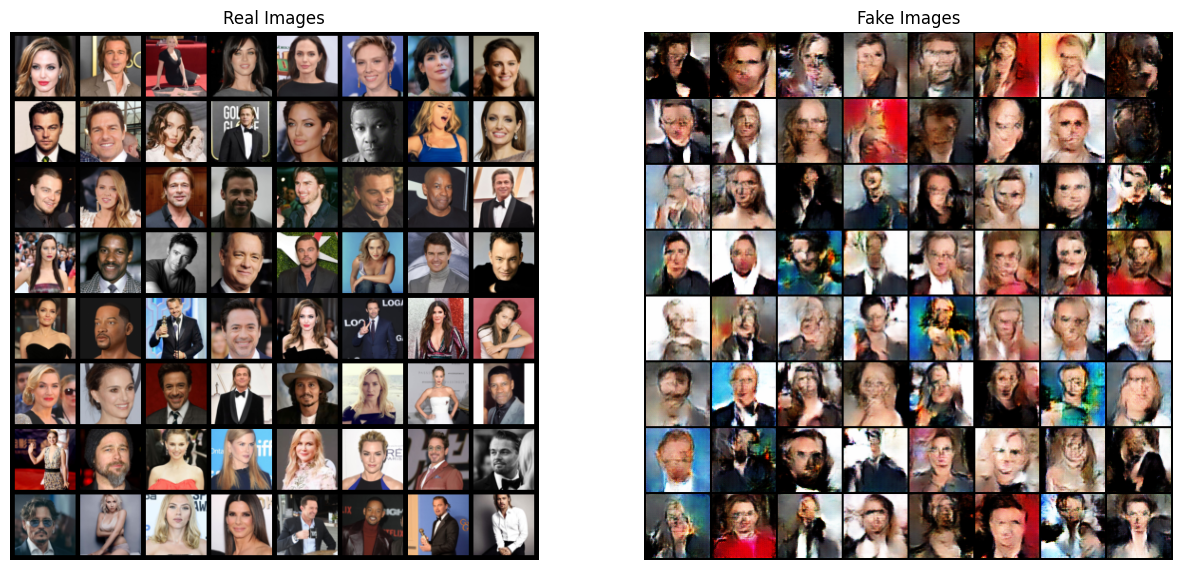

In [29]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()